### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
warnings.filterwarnings('ignore')
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

### Load the data

In [2]:
df = pd.read_csv('auto-mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In [5]:
df.shape

(398, 9)

In [6]:
# checking nulls in columns

df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [7]:
df['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [8]:
#Convert horsepower from categorical to numeric
#Also remove the "?"
df['horsepower'] = df['horsepower'].replace('?', np.nan)
df['horsepower'] = df['horsepower'].apply(lambda x: float(x))

In [9]:
#Lets drop the car names as we do not need it for the purpose of our analysis
df.drop('car name', axis = 1, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 25.0 KB


In [11]:
#The origin column should be categorical for the EDA.
df_eda = df.copy()
df_eda['origin'] = df_eda['origin'].replace({1: 'america', 2: 'europe', 3: 'asia'})

In [12]:
df_eda.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,america
1,15.0,8,350.0,165.0,3693,11.5,70,america
2,18.0,8,318.0,150.0,3436,11.0,70,america
3,16.0,8,304.0,150.0,3433,12.0,70,america
4,17.0,8,302.0,140.0,3449,10.5,70,america


In [13]:
#Lets check the percentage of null values 
df.isnull().mean().sort_values(ascending=False) * 100


horsepower      1.507538
mpg             0.000000
cylinders       0.000000
displacement    0.000000
weight          0.000000
acceleration    0.000000
model year      0.000000
origin          0.000000
dtype: float64

In [14]:
#Impute the missing horsepower values with median
df['horsepower'].fillna(df['horsepower'].median(), inplace=True)
#Do the same for df_eda
df_eda['horsepower'].fillna(df_eda['horsepower'].median(), inplace=True)


In [15]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    object 
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


In [16]:
#The number of cylinders and model year are also categorical variables. Lets convert them appropriately.
# df_eda['cylinders'] = df_eda['cylinders'].apply(lambda x: str(x))
# df_eda['model year'] = df_eda['model year'].apply(lambda x: str(x))


In [17]:
#split the categorical and numeric variables
numeric = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']
categorical = ['cylinders', 'model year', 'origin']

#### Univariate Analysis

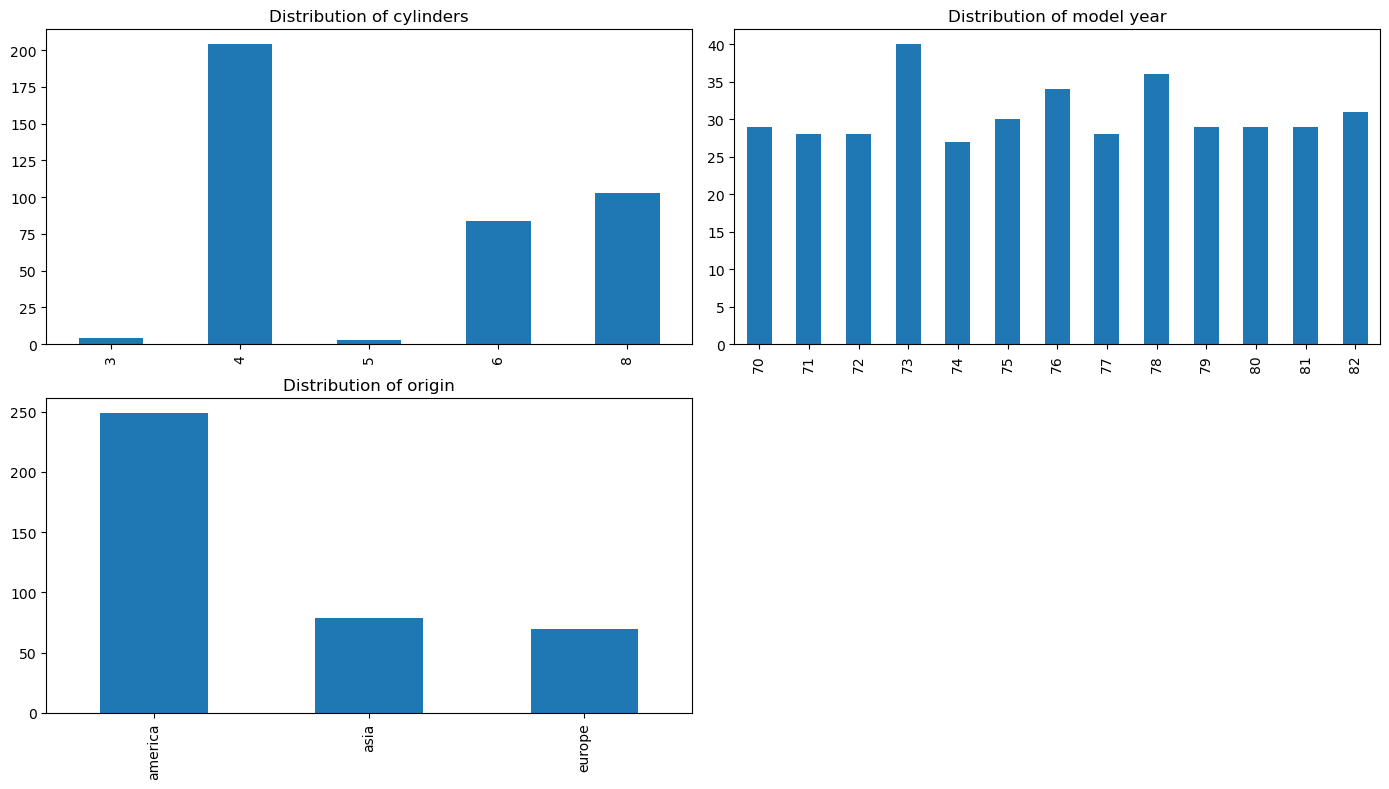

In [18]:
#plotting categorical variables
fig = plt.figure(1, (14, 8))

for i,car in enumerate(df_eda[categorical].columns):
    ax = plt.subplot(2,2,i+1)
    df_eda[car].value_counts().sort_index().plot.bar()
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {car}')
    plt.tight_layout()

plt.show()

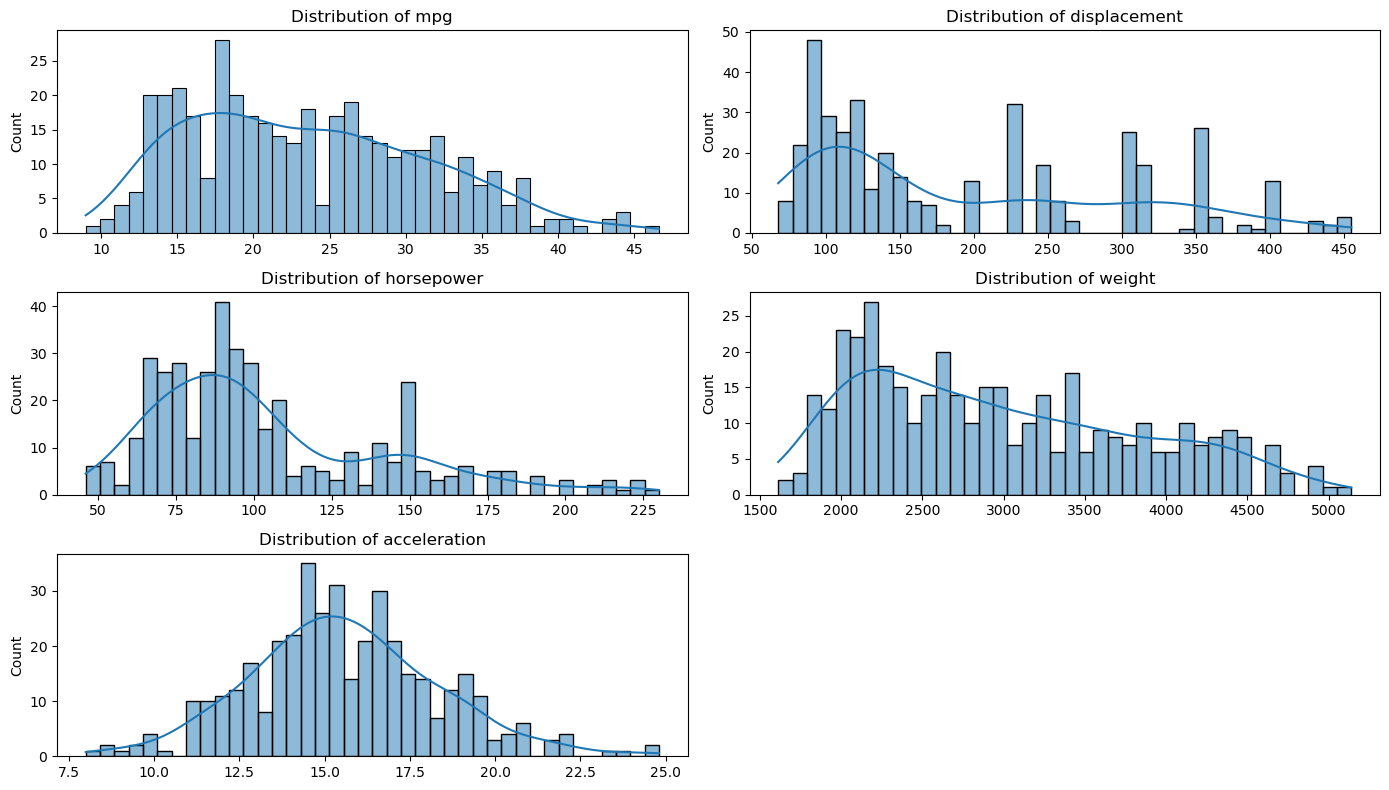

In [19]:
#plotting numeric variables
fig = plt.figure(1, (14, 8))

for i,car in enumerate(df_eda[numeric].columns):
    ax = plt.subplot(3,2,i+1)
    #df_eda[car].plot.hist(bins=30)
    sns.histplot(df_eda[car], kde=True, bins=40)
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {car}')
    plt.tight_layout()

plt.show()

### Bivariate analysis

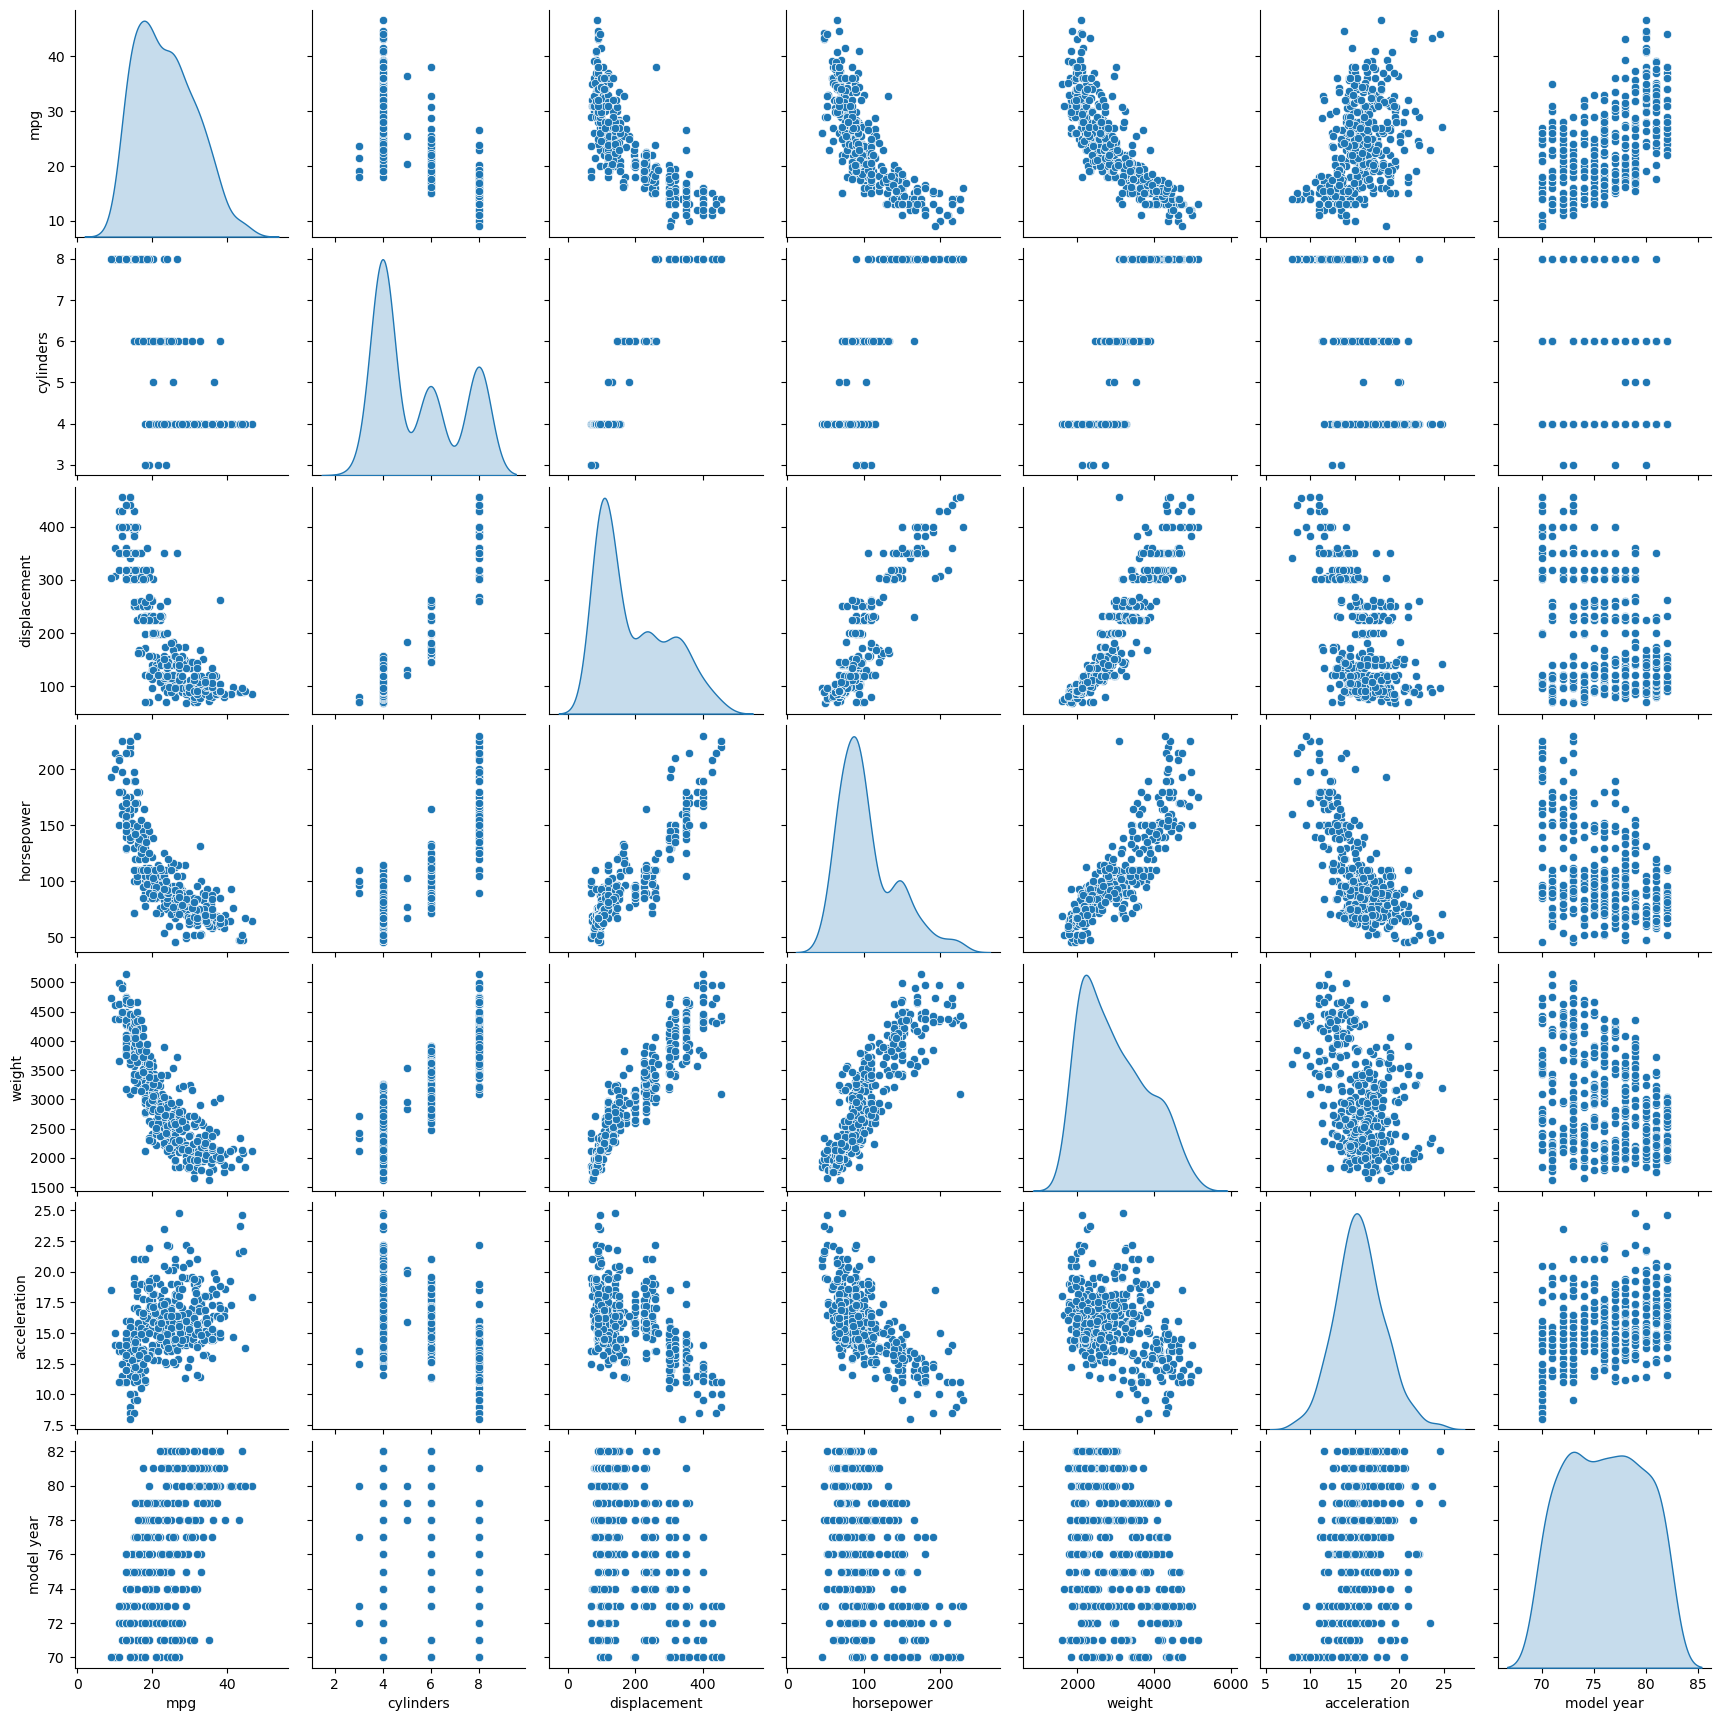

In [20]:
#check the correlation between all the variables
sns.pairplot(df_eda, diag_kind='kde');

- We see that weight, horsepower and displacement are inversely proportional to mpg. 
- Horsepower and displacement are directly proportional to weight
- Horsepower and displacement are directly proportional to each other

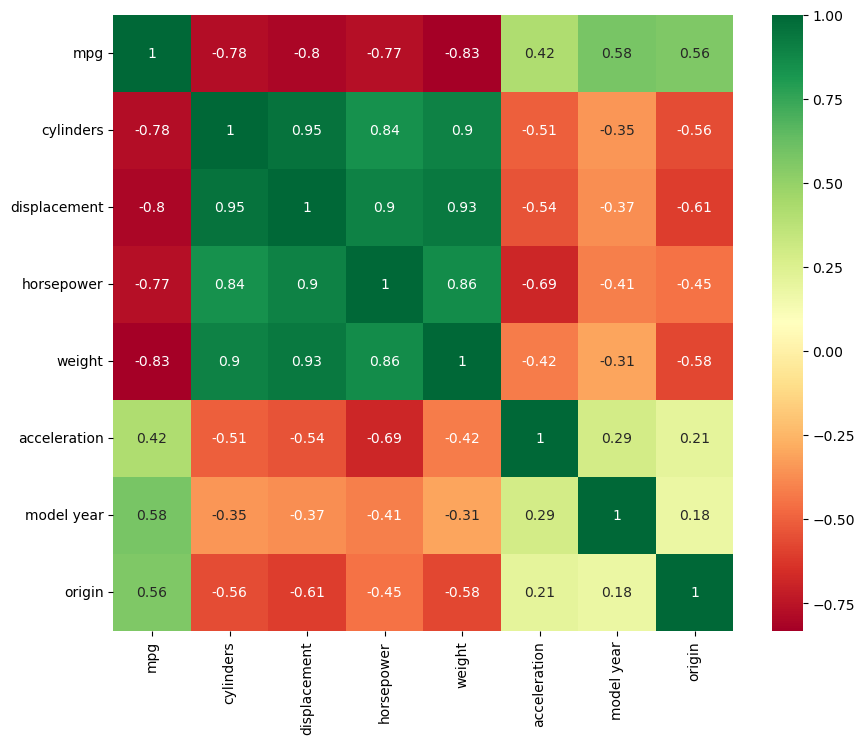

In [21]:
#checking for correlation
plt.figure(figsize=(10,8))
corr=df.corr()
sns.heatmap(corr,cmap = 'RdYlGn',annot=True);


## K-Means Clustering

In [22]:
#standardized feature scaling
df_scaled=df.apply(zscore)
df_scaled.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426,-0.715145
1,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426,-0.715145
2,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426,-0.715145
3,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145
4,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145


In [23]:
#calculating the within sum of squares
wss =[] 
for i in range(1,5):
    KM = KMeans(n_clusters=i)
    KM.fit(df_scaled)
    wss.append(KM.inertia_)

In [24]:
wss

[3184.0, 1588.592456791863, 1190.0436525504851, 987.9431670099705]

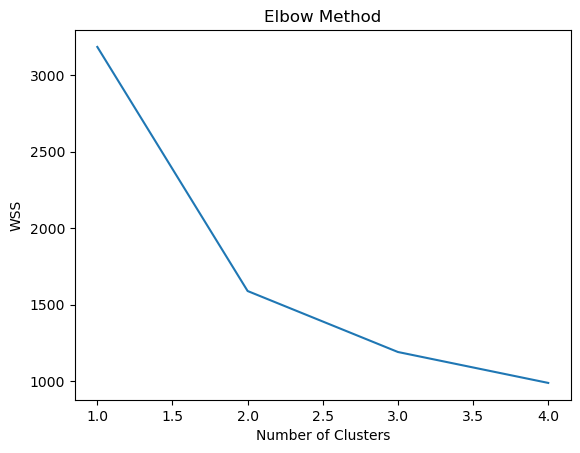

In [25]:
#plotting the WSS against the number of cluster to come up with optimal number of clusters(K) using Elbow-method
plt.plot(range(1,5), wss);
plt.title('Elbow Method');
plt.xlabel("Number of Clusters")
plt.ylabel("WSS");

In [26]:
#using 2 centroids for clustering
k_means = KMeans(n_clusters = 2)
k_means.fit(df_scaled)
labels = k_means.labels_

In [27]:
# Calculating silhouette_score
silhouette_score(df_scaled,labels)

0.4148919831294719

In [28]:
#calculating silhouette score for different centroids
kmeans_kwargs = {
   "init": "random",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
}
silhouette_coefficients = []

#Start at 2 clusters for silhouette coefficient
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_scaled)
    score = silhouette_score(df_scaled,kmeans.labels_)
    silhouette_coefficients.append(score)

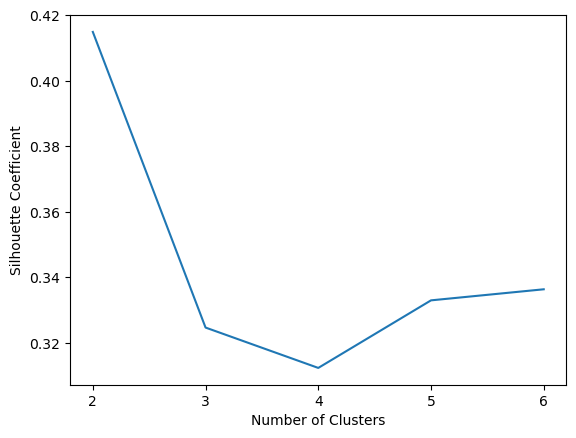

In [29]:
#plotting silhouette score for different centroids
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [30]:
#attaching the labels to the datasets
df["cluster_K"] = labels
Kclus=df
Kclus.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,cluster_K
0,18.0,8,307.0,130.0,3504,12.0,70,1,1
1,15.0,8,350.0,165.0,3693,11.5,70,1,1
2,18.0,8,318.0,150.0,3436,11.0,70,1,1
3,16.0,8,304.0,150.0,3433,12.0,70,1,1
4,17.0,8,302.0,140.0,3449,10.5,70,1,1


In [31]:
#vieweing the distribution of clusters
Kclus.cluster_K.value_counts().sort_index()

0    229
1    169
Name: cluster_K, dtype: int64

In [32]:
#attaching the clusters to the scaled data
df_scaled["cluster_K"] = labels
df_scaled.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,cluster_K
0,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426,-0.715145,1
1,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426,-0.715145,1
2,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426,-0.715145,1
3,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145,1
4,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145,1


In [33]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=Kclus.groupby("cluster_K").mean()
aggdata['Freq']=Kclus.cluster_K.value_counts().sort_index()
aggdata

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,Freq
cluster_K,,,,,,,,,
0,28.735371,4.152838,115.155022,80.849345,2368.759825,16.464192,77.222707,1.982533,229
1,16.440237,7.218935,299.485207,136.085799,3785.698225,14.353846,74.366864,1.017751,169


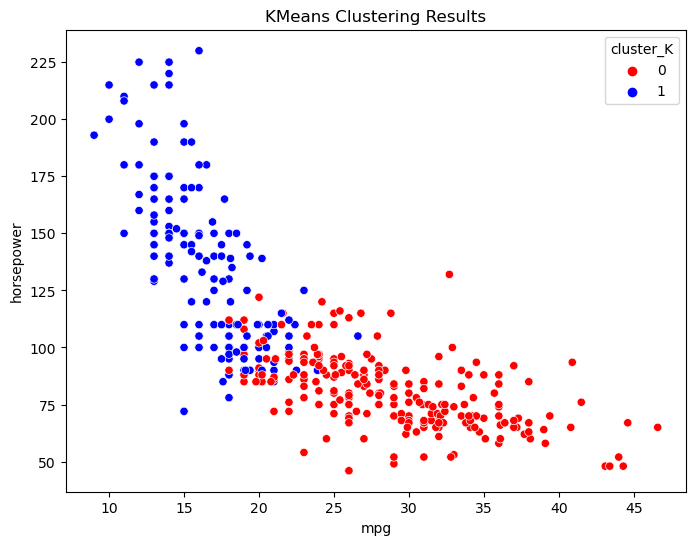

In [34]:
#plotting the clusters
plt.figure(figsize=(8, 6))
plt.title('KMeans Clustering Results')
sns.scatterplot(x="mpg", y="horsepower", hue="cluster_K",
              data=Kclus, 
                    palette=['red','blue']);

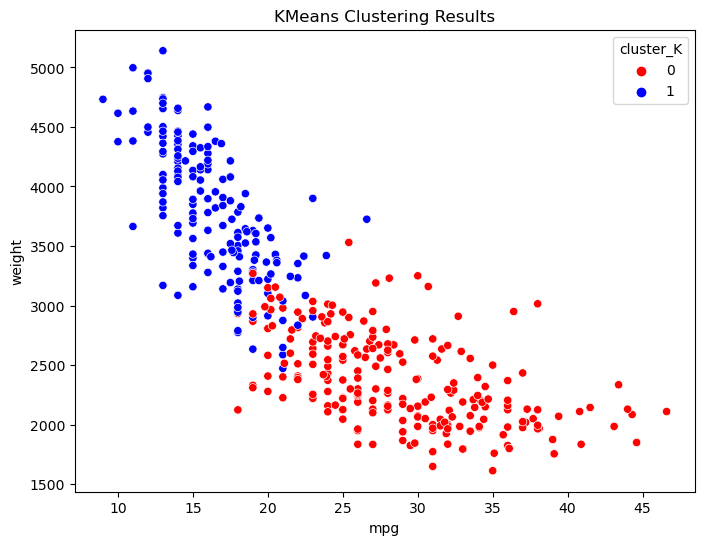

In [35]:
#plotting the clusters
plt.figure(figsize=(8, 6))
plt.title('KMeans Clustering Results')
sns.scatterplot(x="mpg", y="weight", hue="cluster_K",
              data=Kclus, 
                    palette=['red','blue']);

## Spectral Clustering

In [36]:
# Drop any non-numeric columns
numeric_df = df.drop(['origin','cluster_K'], axis=1)

In [37]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

In [38]:
# Compute pairwise distances
distance_matrix = pairwise_distances(scaled_data, metric='euclidean')

# Convert distance matrix to affinity matrix
affinity_matrix = np.exp(-distance_matrix ** 2 / (2. * np.std(distance_matrix) ** 2))

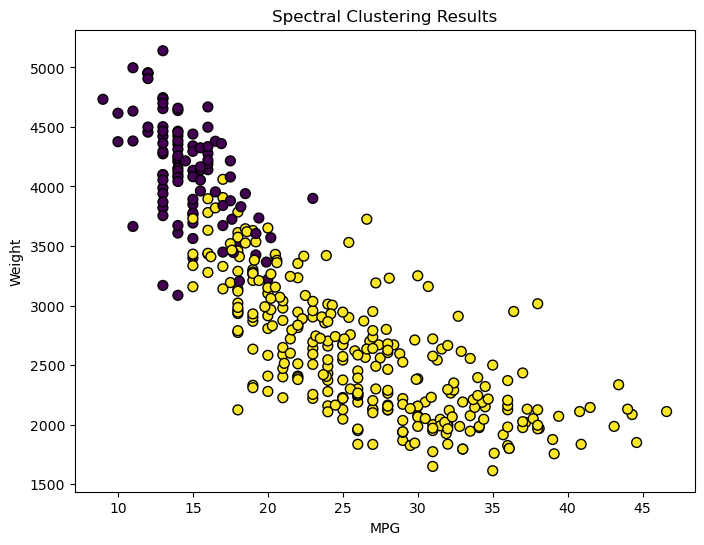

In [39]:
# Perform spectral clustering
n_clusters = 2  # Set the number of clusters
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
df['cluster_S'] = spectral.fit_predict(affinity_matrix)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(df['mpg'], df['weight'], c=df['cluster_S'], cmap='viridis', edgecolor='k', s=50)
plt.title('Spectral Clustering Results')
plt.xlabel('MPG')
plt.ylabel('Weight')
plt.show()

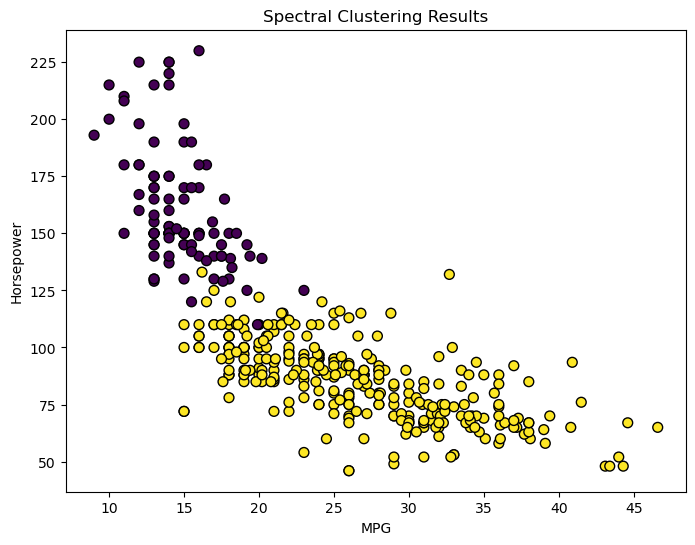

In [40]:
# Plot the clusters for 'mpg' versus 'horsepower'
plt.figure(figsize=(8, 6))
plt.scatter(df['mpg'], df['horsepower'], c=df['cluster_S'], cmap='viridis', edgecolor='k', s=50)
plt.title('Spectral Clustering Results')
plt.xlabel('MPG')
plt.ylabel('Horsepower')
plt.show()

In [41]:
df1=df.copy()

## Hierarchial Clustering

In [42]:

#removing the cluster_K column
df.drop('cluster_K', axis=1, inplace=True) 
df

#removing the cluster_S column
df.drop('cluster_S', axis=1, inplace=True) 
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1


In [43]:
#standardized feature scaling
df_scaled_h=df.apply(zscore)
df_scaled_h.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426,-0.715145
1,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426,-0.715145
2,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426,-0.715145
3,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145
4,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145


In [44]:
#calculating pairwise distance using average linkage method
link_method = linkage(df_scaled_h, method = 'average')

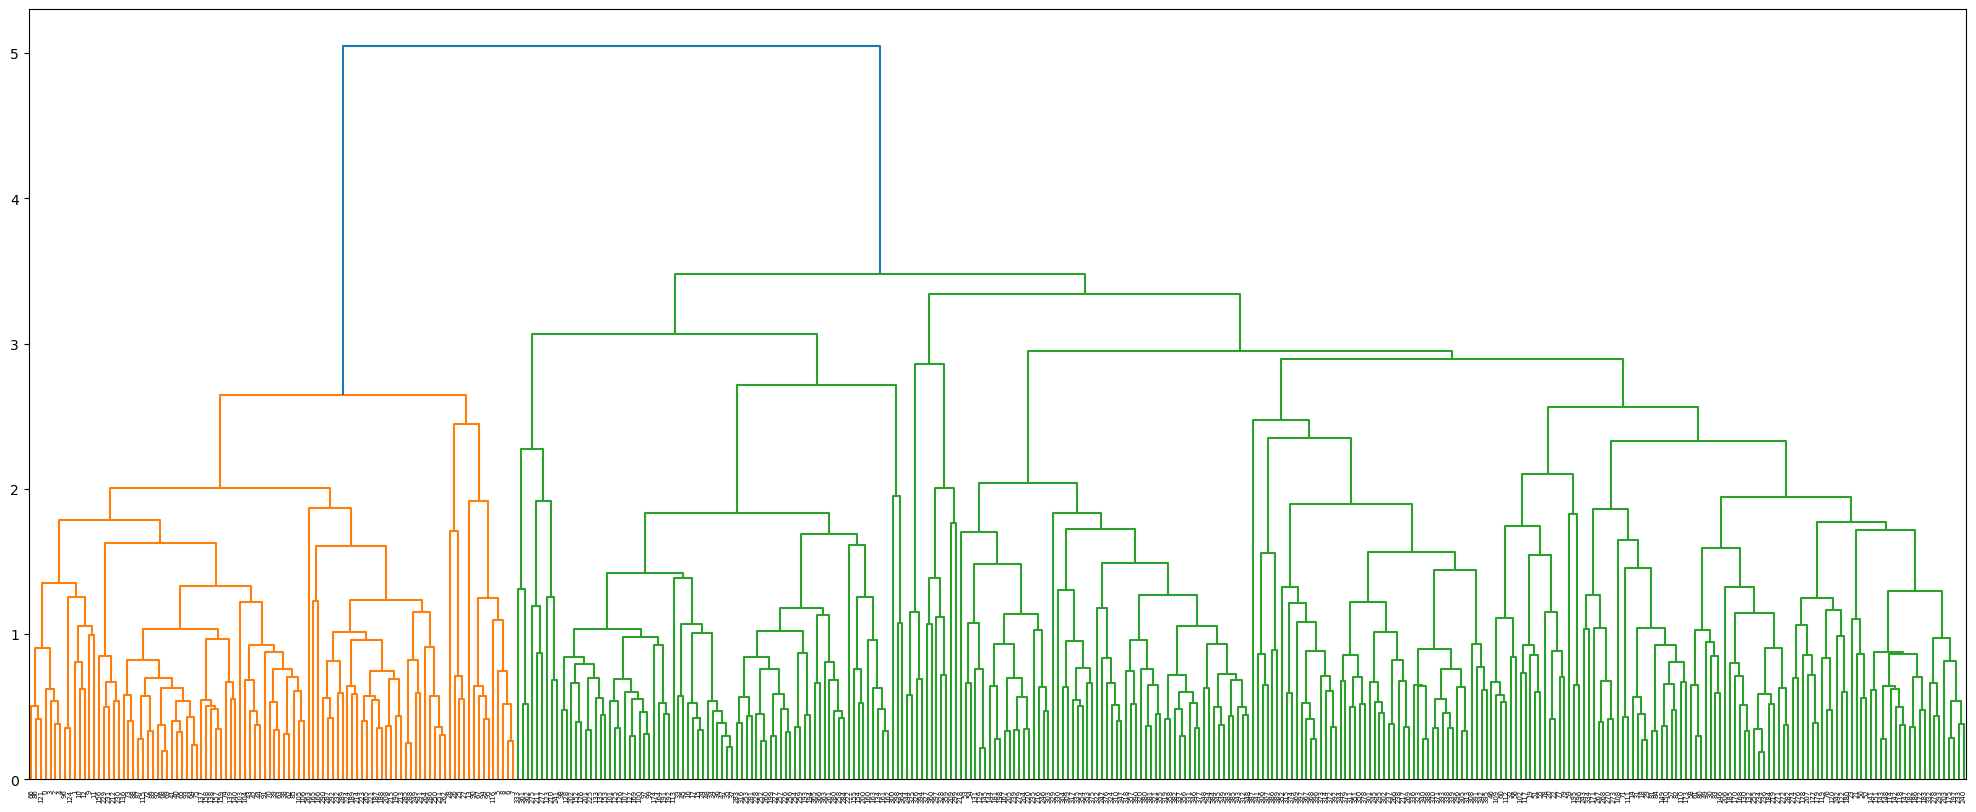

In [45]:
#plotting the H-cluster
plt.figure(figsize=(25, 10))
dendrogram(link_method)
plt.show()

Let's simplify it by adjusting the dendrogram to yield just 2 clusters.

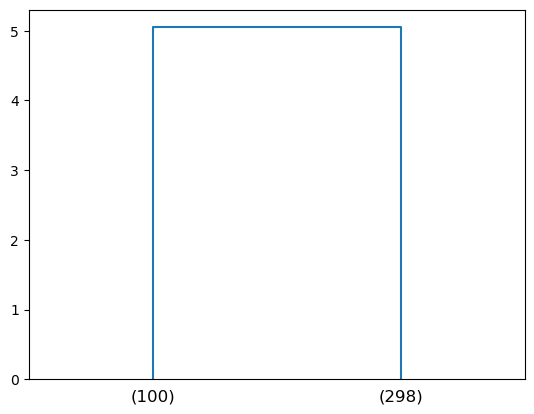

In [46]:
# Simplifying into 2 clusters
dendrogram(
    link_method,
    truncate_mode='lastp',  
    p=2,  
)
plt.show()


In [47]:
#Displaying the clusters
clusters = fcluster(link_method, 2, criterion='maxclust')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,

In [48]:
#attaching the clusters formed to the scaled data
df_scaled_h['cluster_H'] = clusters
df_scaled_h.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,cluster_H
0,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426,-0.715145,1
1,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426,-0.715145,1
2,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426,-0.715145,1
3,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145,1
4,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145,1


In [49]:

#distribution of clusters
df_scaled_h.cluster_H.value_counts().sort_index()

1    100
2    298
Name: cluster_H, dtype: int64

In [50]:
#attaching the clusters formed to the original data
df['cluster_H']=clusters
df.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,cluster_H
0,18.0,8,307.0,130.0,3504,12.0,70,1,1
1,15.0,8,350.0,165.0,3693,11.5,70,1,1
2,18.0,8,318.0,150.0,3436,11.0,70,1,1
3,16.0,8,304.0,150.0,3433,12.0,70,1,1
4,17.0,8,302.0,140.0,3449,10.5,70,1,1


In [51]:

#create a new data set named Hclus
Hclus=df
Hclus.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,cluster_H
0,18.0,8,307.0,130.0,3504,12.0,70,1,1
1,15.0,8,350.0,165.0,3693,11.5,70,1,1
2,18.0,8,318.0,150.0,3436,11.0,70,1,1
3,16.0,8,304.0,150.0,3433,12.0,70,1,1
4,17.0,8,302.0,140.0,3449,10.5,70,1,1


In [52]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=df.groupby('cluster_H').mean()
aggdata['Freq']=df.cluster_H.value_counts().sort_index()
aggdata


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,Freq
cluster_H,,,,,,,,,
1,14.684000,7.980000,345.470000,160.400000,4121.560000,12.702000,73.740000,1.000000,100
2,26.477852,4.607383,142.404362,85.479866,2584.137584,16.529866,76.771812,1.765101,298


The dendrogram distinctly reveals two separate groups, each demonstrating a difference in the average values across the clusters and their respective variables.

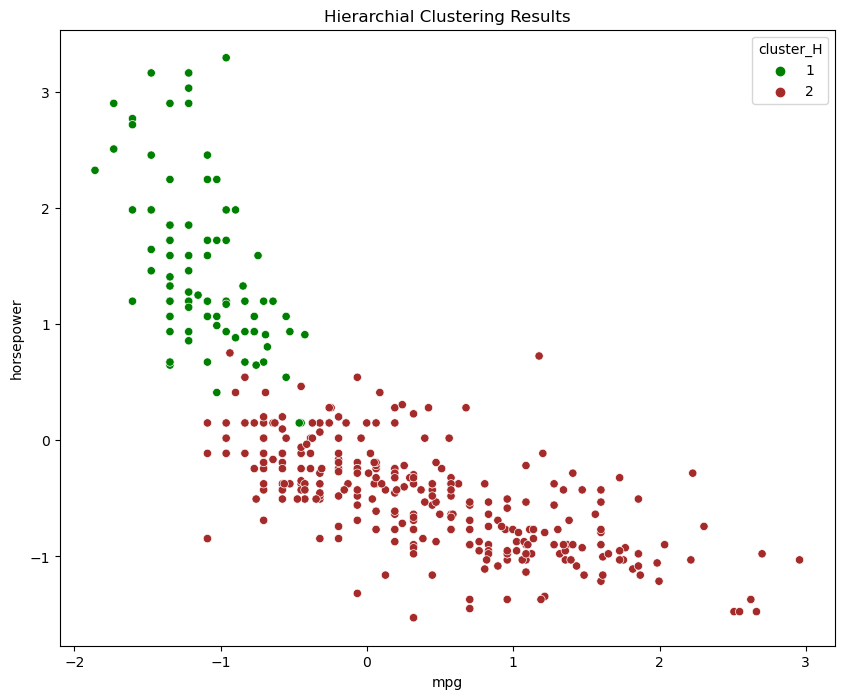

In [84]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
plt.title('Hierarchial Clustering Results')
sns.scatterplot(x="mpg", y="horsepower", hue="cluster_H",
              data=df_scaled_h, 
                    palette=['green','brown']);

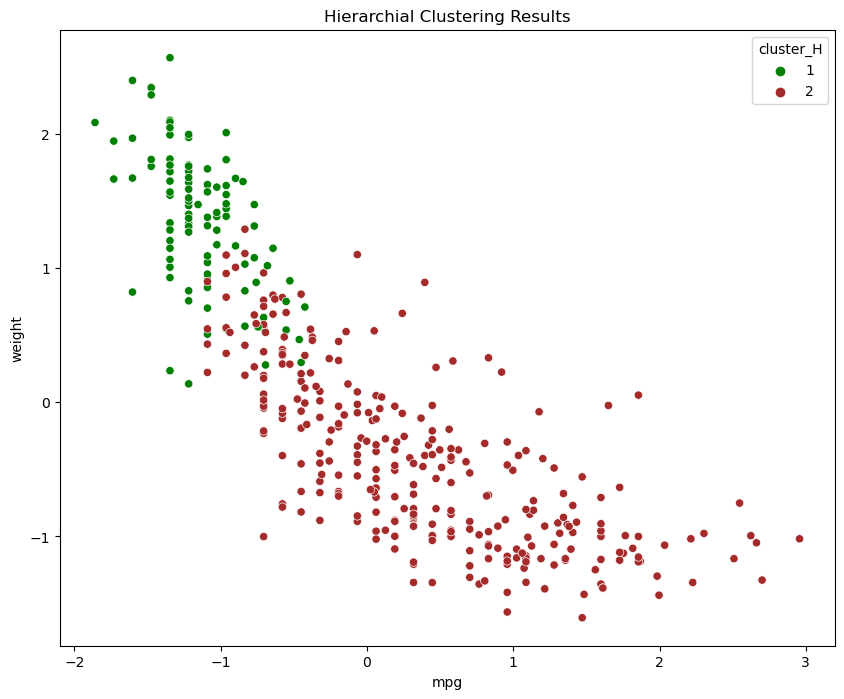

In [85]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
plt.title('Hierarchial Clustering Results')
sns.scatterplot(x="mpg", y="weight", hue="cluster_H",
              data=df_scaled_h, 
                    palette=['green','brown']);

### Principal Component Analysis (PCA)

In [55]:
df_pca = df.iloc[:, :7]
df_pca

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year
0,18.0,8,307.0,130.0,3504,12.0,70
1,15.0,8,350.0,165.0,3693,11.5,70
2,18.0,8,318.0,150.0,3436,11.0,70
3,16.0,8,304.0,150.0,3433,12.0,70
4,17.0,8,302.0,140.0,3449,10.5,70
...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82
394,44.0,4,97.0,52.0,2130,24.6,82
395,32.0,4,135.0,84.0,2295,11.6,82
396,28.0,4,120.0,79.0,2625,18.6,82


In [56]:
# scaling the data
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(df_pca), columns=df_pca.columns)

In [57]:
data_scaled.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year
0,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426
1,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426
2,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426
3,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426
4,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426


In [58]:
#Defining the number of principal components to generate 
n=data_scaled.shape[1]

#Finding principal components for the data
pca = PCA(n_components=n,random_state = 1) #Apply the PCA algorithm with random state = 1
data_pca1 = pd.DataFrame(pca.fit_transform(data_scaled)) #Fit and transform the pca function on scaled data

#The percentage of variance explained by each principal component
exp_var = pca.explained_variance_ratio_

Text(0, 0.5, 'Cumulative Explained Variance')

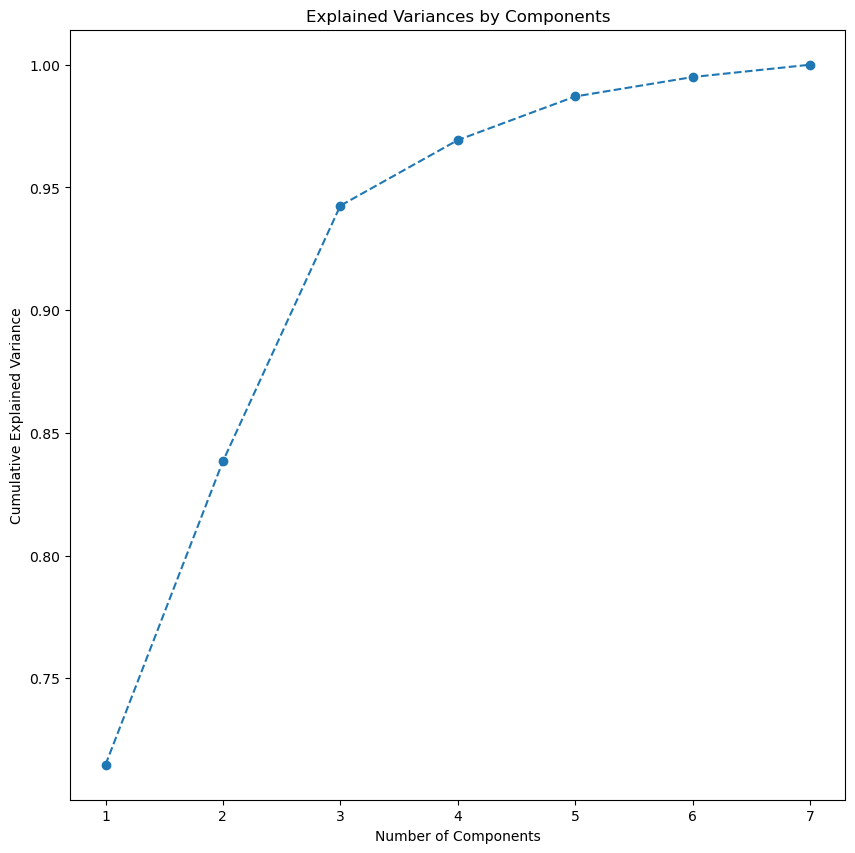

In [59]:
# visualizing the explained variance by individual components
plt.figure(figsize = (10,10))
plt.plot(range(1,8), exp_var.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [60]:
# finding the least number of components that can explain more than 90% variance
sum = 0
for ix, i in enumerate(exp_var):
  sum = sum + i
  if(sum>0.90):
    print("Number of PCs that explain at least 90% variance: ", ix+1)
    break

Number of PCs that explain at least 90% variance:  3


Observations:

We can see that a large percentage of the variation can be explained by 3 principal components. More specifically, they explain almost 95% of the variance as we can see in the above results.

This lets us reduce the number of dimensions significantly.

In [61]:
pc_comps = ['PC1','PC2','PC3']
data_pca = pd.DataFrame(np.round(pca.components_[:3,:],2),index=pc_comps,columns=data_scaled.columns)
data_pca.T

,PC1,PC2,PC3
mpg,-0.40,-0.21,-0.26
cylinders,0.42,-0.19,0.14
displacement,0.43,-0.18,0.10
horsepower,0.42,-0.09,-0.17
weight,0.41,-0.22,0.28
acceleration,-0.28,0.02,0.89
model year,-0.23,-0.91,-0.02


Let's look at the coefficients of three principal components from the below dataframe



In [62]:
def color_high(val):
    if val <= -0.40: # you can decide any value as per your understanding
        return 'background: pink'
    elif val >= 0.40:
        return 'background: skyblue'   
    
data_pca.T.style.applymap(color_high)

,PC1,PC2,PC3
mpg,-0.400000,-0.210000,-0.260000
cylinders,0.420000,-0.190000,0.140000
displacement,0.430000,-0.180000,0.100000
horsepower,0.420000,-0.090000,-0.170000
weight,0.410000,-0.220000,0.280000
acceleration,-0.280000,0.020000,0.890000
model year,-0.230000,-0.910000,-0.020000


Observations:

The first principle component seems to have high coefficients for cylinders, displacement, horsepower, and weight and a very low coefficient for mpg- this seems to be associated with cars that are bigger and heavier with more cylinders and less fuel efficient.

PC2 has a very low coefficient for model year, so it seems to be associated with cars that have typical values for older cars.

PC3 has a low coefficient for acceleration

We can also visualize the data in 2 dimensions using first two principal components

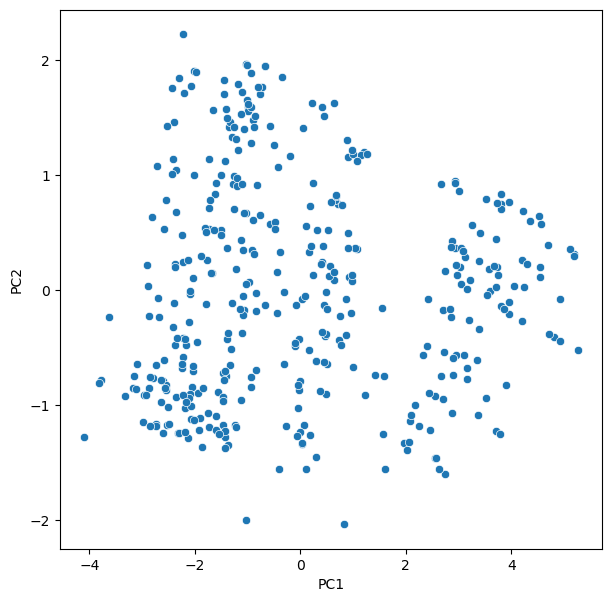

In [63]:
plt.figure(figsize = (7,7))
sns.scatterplot(x=data_pca1[0],y=data_pca1[1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Text(0, 0.5, 'PC2')

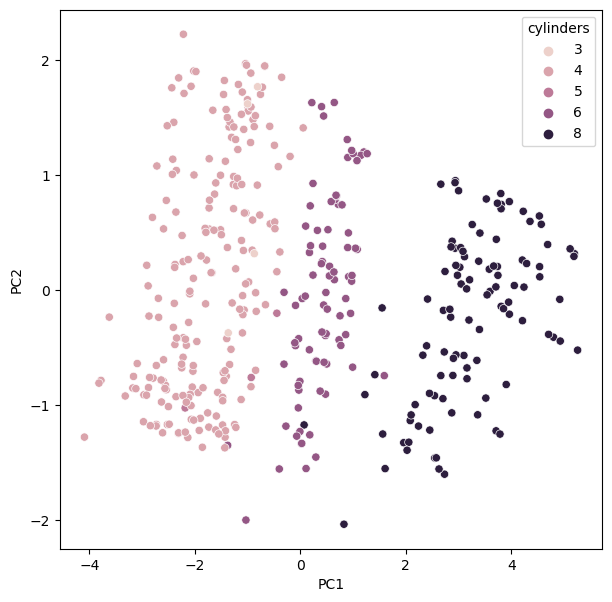

In [64]:
df_concat = pd.concat([data_pca1, df_eda], axis=1)

plt.figure(figsize = (7,7))
#Create a scatter plot with x=0 and y=1 using df_concat dataframe
sns.scatterplot(x = 0, y = 1, data=df_concat, hue = 'cylinders')

plt.xlabel("PC1")
plt.ylabel("PC2")

Observations:

We see 3 different clusters:

one of them has 3-5 cylinders
the other has 6 cylinders
the last one has 8 cylinders
Some values overlap

## Regression

In [65]:
X=df_scaled.drop(['mpg','cluster_K'],axis=1)
y=df_scaled['mpg']

In [66]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost regression model
x_model = XGBRegressor()
# Create an Linear regression model
l_model = LinearRegression()

In [67]:
# Train the model
x_model.fit(X_train, y_train)
l_model.fit(X_train, y_train)


# Evaluate the model
xscore = x_model.score(X_test,y_test)
print(f'Score for XGBoost regression model on test data: {xscore}')
lscore = l_model.score(X_test,y_test)
print(f'Score for Linear regression model on test data {lscore}')
# Evaluate the model on train
xscore_train = x_model.score(X_train,y_train)
print(f'Score for XGBoost regression model on train data: {xscore_train}')
lscore_train = l_model.score(X_train,y_train)
print(f'Score for Linear regression model on train data {lscore_train}')

Score for XGBoost regression model on test data: 0.8606399597082741
Score for Linear regression model on test data 0.8475304239212407
Score for XGBoost regression model on train data: 0.9999870308290731
Score for Linear regression model on train data 0.8140179390257464


## Regression using k-means cluster

In [68]:
#renaming the cluster labels to light and heavy vehicles and creating dummy variables of it
df_scaled['cluster_K']=df_scaled['cluster_K'].astype('category')
df_scaled['cluster_K'] = df_scaled['cluster_K'].replace({1: 'heavy', 0: 'light'})
df_scaled = pd.get_dummies(df_scaled, columns=['cluster_K'])

In [69]:
df_scaled

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,cluster_K_light,cluster_K_heavy
0,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426,-0.715145,0,1
1,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426,-0.715145,0,1
2,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426,-0.715145,0,1
3,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145,0,1
4,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145,0,1
...,...,...,...,...,...,...,...,...,...,...
393,0.446497,-0.856321,-0.513026,-0.479482,-0.213324,0.011586,1.621983,-0.715145,1,0
394,2.624265,-0.856321,-0.925936,-1.370127,-0.993671,3.279296,1.621983,0.533222,1,0
395,1.087017,-0.856321,-0.561039,-0.531873,-0.798585,-1.440730,1.621983,-0.715145,1,0
396,0.574601,-0.856321,-0.705077,-0.662850,-0.408411,1.100822,1.621983,-0.715145,1,0


In [70]:
X1=df_scaled.drop(['mpg','cluster_K_light'],axis=1)
y1=df_scaled['mpg']

In [71]:
# Split the dataset into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Create an XGBoost regression model
x_model1 = XGBRegressor()
# Create an Linear regression model
l_model1 = LinearRegression()

In [72]:
# Train the model
x_model1.fit(X_train1, y_train1)
l_model1.fit(X_train1, y_train1)


# Evaluate the model
xscore1 = x_model1.score(X_test1,y_test1)
print(f'Score for XGBoost regression model on test data: {xscore1}')
lscore1 = l_model1.score(X_test1,y_test1)
print(f'Score for Linear regression model on test data {lscore1}')
# Evaluate the model on train
xscore_train1 = x_model1.score(X_train1,y_train1)
print(f'Score for XGBoost regression model on train data: {xscore_train1}')
lscore_train1 = l_model1.score(X_train1,y_train1)
print(f'Score for Linear regression model on train data {lscore_train1}')

Score for XGBoost regression model on test data: 0.900343044892624
Score for Linear regression model on test data 0.8621514296024916
Score for XGBoost regression model on train data: 0.999984242273834
Score for Linear regression model on train data 0.8220745711238636


## Regression using Hierarchial Clustering


In [73]:
#renaming the cluster labels to light and heavy vehicles and creating dummy variables of it
df['cluster_H']=df['cluster_H'].astype('category')
df['cluster_H'] = df['cluster_H'].replace({1: 'heavy', 0: 'light'})
df = pd.get_dummies(df, columns=['cluster_H'])

In [74]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,cluster_H_heavy,cluster_H_2
0,18.0,8,307.0,130.0,3504,12.0,70,1,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,1,0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1,0,1
394,44.0,4,97.0,52.0,2130,24.6,82,2,0,1
395,32.0,4,135.0,84.0,2295,11.6,82,1,0,1
396,28.0,4,120.0,79.0,2625,18.6,82,1,0,1


In [75]:
X2=df.drop(['mpg','cluster_H_2'],axis=1)
y2=df['mpg']

In [76]:
# Split the dataset into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Create an XGBoost regression model
x_model2 = XGBRegressor()
# Create an Linear regression model
l_model2 = LinearRegression()

In [77]:
# Train the model
x_model2.fit(X_train2, y_train2)
l_model2.fit(X_train2, y_train2)


# Evaluate the model
xscore2 = x_model2.score(X_test2,y_test2)
print(f'Score for XGBoost regression model on test data: {xscore2}')
lscore2 = l_model2.score(X_test2,y_test2)
print(f'Score for Linear regression model on test data {lscore2}')
# Evaluate the model on train
xscore_train2 = x_model2.score(X_train2,y_train2)
print(f'Score for XGBoost regression model on train data: {xscore_train2}')
lscore_train2 = l_model2.score(X_train2,y_train2)
print(f'Score for Linear regression model on train data {lscore_train2}')

Score for XGBoost regression model on test data: 0.8919379400496753
Score for Linear regression model on test data 0.8544542901079483
Score for XGBoost regression model on train data: 0.9999845301967437
Score for Linear regression model on train data 0.82320506145076


## Regression using Spectral Clustering


In [78]:
#renaming the cluster labels to light and heavy vehicles and creating dummy variables of it
df1['cluster_S']=df1['cluster_S'].astype('category')
df1['cluster_S'] = df1['cluster_S'].replace({1: 'heavy', 0: 'light'})
df1 = pd.get_dummies(df1, columns=['cluster_S'])

In [79]:
X3=df1.drop(['mpg','cluster_K','cluster_S_heavy'],axis=1)
y3=df1['mpg']

In [80]:
# Split the dataset into training and testing sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

# Create an XGBoost regression model
x_model3 = XGBRegressor()
# Create an Linear regression model
l_model3 = LinearRegression()

In [81]:
# Train the model
x_model3.fit(X_train3, y_train3)
l_model3.fit(X_train3, y_train3)


# Evaluate the model
xscore3 = x_model3.score(X_test3,y_test3)
print(f'Score for XGBoost regression model on test data: {xscore3}')
lscore3 = l_model3.score(X_test3,y_test3)
print(f'Score for Linear regression model on test data {lscore3}')
# Evaluate the model on train
xscore_train3 = x_model3.score(X_train3,y_train3)
print(f'Score for XGBoost regression model on train data: {xscore_train3}')
lscore_train3 = l_model3.score(X_train3,y_train3)
print(f'Score for Linear regression model on train data {lscore_train3}')

Score for XGBoost regression model on test data: 0.8879278600890455
Score for Linear regression model on test data 0.8603984427719319
Score for XGBoost regression model on train data: 0.9999845301967437
Score for Linear regression model on train data 0.82320506145076


In [86]:
modellists = []
modellists.append(['Regression on Original Data set',xscore*100,lscore*100,xscore_train*100, lscore_train*100])
modellists.append(['Regression with K means clusters', xscore1*100,lscore1*100,xscore_train1*100, lscore_train1*100])
modellists.append(['Regression with Heirarchical clusters', xscore2*100,lscore2*100,xscore_train2*100, lscore_train2*100])
modellists.append(['Regression with Spectral clusters',xscore3*100,lscore3*100,xscore_train3*100, lscore_train3*100])
mdl_df = pd.DataFrame(modellists, columns = ['Model','test score-XGBoost Regression','test score-Linear Regression','train score-XGBoost Regression','train score-Linear Regression'])

In [87]:
mdl_df

,Model,test score-XGBoost Regression,test score-Linear Regression,train score-XGBoost Regression,train score-Linear Regression
0,Regression on Original Data set,86.063996,84.753042,99.998703,81.401794
1,Regression with K means clusters,90.034304,86.215143,99.998424,82.207457
2,Regression with Heirarchical clusters,89.193794,85.445429,99.998453,82.320506
3,Regression with Spectral clusters,88.792786,86.039844,99.998453,82.320506
